LINEAR REGRESSION 

In [1]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('CO2_Emissions_Canada.csv')
df.head(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
df.nunique()

Make                                  42
Model                               2053
Vehicle Class                         16
Engine Size(L)                        51
Cylinders                              8
Transmission                          27
Fuel Type                              5
Fuel Consumption City (L/100 km)     211
Fuel Consumption Hwy (L/100 km)      143
Fuel Consumption Comb (L/100 km)     181
Fuel Consumption Comb (mpg)           54
CO2 Emissions(g/km)                  331
dtype: int64

In [4]:
df.isnull().values.sum(axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
class TargetEncoder :
    
    def __init__(self, target, smooth_k=5):
        self.target = target
        self.smooth_k = smooth_k
        self.original_feature = None
        self.mapping = defaultdict(lambda:0)
        self.global_mean = 0
        
    def fit(self, X_train, y_train):
        self.original_feature = X_train.name
        self.global_mean = y_train.mean()

        stats = X_train.to_frame(self.original_feature).copy()
        stats[self.target] = y_train
        
        agg = stats.groupby(self.original_feature)[self.target].agg(['count', 'mean'])
        agg['smooth_mean'] = (agg['count'] * agg['mean'] + self.smooth_k * self.global_mean) / (agg['count']+self.smooth_k)
        self.mapping = agg['smooth_mean'].to_dict()
        return self 
    
    def transform(self, X):
        return X.map(self.mapping).fillna(self.global_mean)
    
    def fit_transform(self, X_train, y_train):
        self.fit(X_train,y_train)
        return self.transform(X_train)
    

In [6]:


def preprocessed_data(df, target_encoder = None, fit_mode = False):
    TARGET = 'CO2 Emissions(g/km)'
    HIGH_CARDINALITY_FEATURE = 'Model' 
    LOW_CARD_FEATURES = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']
    NUMERICAL_FEATURES = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                          'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)', 
                          'Fuel Consumption Comb (mpg)']
    if fit_mode:
        encoders = {
            'target_encoder': TargetEncoder(TARGET, smooth_k=5),
            'imputers': {},
            'label_encoders': {}
        }
    else:
        if target_encoder is None:
            raise ValueError("TargetEncoder must be provided when not in fit_mode.")
        encoders = target_encoder
        
    df_processed = df.copy()
    
    y_target = df_processed[TARGET] if TARGET in df_processed.columns else None
    X_features = df_processed.drop(columns=[TARGET]) if TARGET in df_processed.columns else df_processed
    
    all_features = NUMERICAL_FEATURES + LOW_CARD_FEATURES + [HIGH_CARDINALITY_FEATURE]
    for col in all_features:
        if col in X_features.columns and X_features[col].isnull().any():
            if col in NUMERICAL_FEATURES:
                impute_func = 'mean'
            else: 
                impute_func = 'mode'
                
            if fit_mode:
                imputer_val = X_features[col].mode()[0] if impute_func == 'mode' else X_features[col].mean()
                encoders['imputers'][col] = imputer_val
    if fit_mode:
        X_features[HIGH_CARDINALITY_FEATURE + '_encoded'] = encoders['target_encoder'].fit_transform(
            X_features[HIGH_CARDINALITY_FEATURE], y_target
        )
    else:
        X_features[HIGH_CARDINALITY_FEATURE + '_encoded'] = encoders['target_encoder'].transform(
            X_features[HIGH_CARDINALITY_FEATURE]
        )
    X_features = X_features.drop(columns=[HIGH_CARDINALITY_FEATURE])
    
    for col in LOW_CARD_FEATURES:
        if col in X_features.columns:
            if fit_mode:
                le = LabelEncoder()
                X_features[col + '_encoded'] = le.fit_transform(X_features[col])
                encoders['label_encoders'][col] = le
            else:
                le = encoders['label_encoders'][col]
                mapping = {cls: i for i, cls in enumerate(le.classes_)}
                X_features[col + '_encoded'] = X_features[col].map(mapping).fillna(-1) 
            
            X_features = X_features.drop(columns=[col])
    if fit_mode:
        X_features[TARGET] = y_target 
        return X_features, encoders
    else:
        return X_features, encoders
    

In [7]:
shuffle_df = df.sample(frac=1, random_state=42)
train_ratio = 0.75
split_index = int(train_ratio*len(shuffle_df))
train_df = shuffle_df[:split_index].reset_index(drop=True)
test_df = shuffle_df[split_index:].reset_index(drop=True)

In [8]:
train_df.shape

(5538, 12)

In [9]:
test_df.shape

(1847, 12)

In [10]:
train_processed, encoders = preprocessed_data(train_df, fit_mode=True)
test_processed, encoders = preprocessed_data(test_df, fit_mode=True)

In [11]:
train_processed.head(5)

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),Model_encoded,Make_encoded,Vehicle Class_encoded,Transmission_encoded,Fuel Type_encoded,CO2 Emissions(g/km)
0,3.0,6,12.4,9.0,10.9,26,251.241113,32,1,10,4,253
1,4.4,8,17.3,11.6,14.7,19,301.263414,5,10,9,4,344
2,6.2,8,16.1,11.4,14.0,20,286.404621,15,6,5,4,322
3,5.3,8,14.6,10.3,12.7,22,283.484390,9,6,3,3,297
4,4.0,6,14.3,11.9,13.2,21,260.114632,39,12,14,3,308


In [12]:
TARGET = 'CO2 Emissions(g/km)'

X_train = train_processed.drop(TARGET, axis=1)
y_train = train_processed[TARGET]

X_test = test_processed.drop(columns=[TARGET], errors='ignore') 
y_test = test_df[TARGET]

In [13]:
linReg = LinearRegression()
linReg.fit(X_train,y_train)
predict = linReg.predict(X_test)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

mse = mean_squared_error(y_test, predict)
print(mse)
r2 = r2_score(y_test, predict)
print(r2)

299.98273977781975
0.9155071413639356


In [15]:
alpha_ridge = 1  # A common starting value. You can tune this later!
print(f"\n--- 3B. Training Ridge Regression Model (Alpha={alpha_ridge}) ---")
    
model_ridge = Ridge(alpha=alpha_ridge)
    # FITTING THE MODEL
model_ridge.fit(X_train, y_train) 
    
    # Make Predictions
y_pred_ridge = model_ridge.predict(X_test)
    
    # Evaluate Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge R2 Score: {r2_ridge:.4f} | MSE: {mse_ridge:.2f}")
    
    # 7. Final Comparison and Coefficients

    
if r2_ridge > r2:
    print("🎉 Ridge Regression performed better on the test set!")
    best_model = model_ridge
    best_X_train = X_train
    r2_best = r2_ridge
    mse_best = mse_ridge
else:
    print("Standard Linear Regression performed better or equally well.")
    best_model = linReg
    best_X_train = X_train
    r2_best = r2
    mse_best = mse
        
print(f"BEST MODEL R2 Score: {r2_best:.4f}, MSE: {mse_best:.2f}")


--- 3B. Training Ridge Regression Model (Alpha=1) ---
Ridge R2 Score: 0.9155 | MSE: 299.95
🎉 Ridge Regression performed better on the test set!
BEST MODEL R2 Score: 0.9155, MSE: 299.95


In [16]:
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='teal', edgecolors='w')
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='orangered', linestyle='--', linewidth=2, label='Perfect Prediction')
    
    plt.title(f'Actual vs. Predicted CO2 Emissions ({model_name})', fontsize=16)
    plt.xlabel('Actual CO2 Emissions (g/km)', fontsize=14)
    plt.ylabel('Predicted CO2 Emissions (g/km)', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.show()
    
def plot_coefficients(coefficients, model_name):

    coefficients = coefficients.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    colors = ['green' if c > 0 else 'red' for c in coefficients.values]
    coefficients.plot(kind='bar', color=colors)
    
    plt.title(f'Model Coefficients for {model_name}', fontsize=16)
    plt.ylabel('Coefficient Value', fontsize=14)
    plt.xlabel('Feature', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout() 
    plt.show()

In [17]:
coefficients = pd.Series(best_model.coef_, index = best_X_train.columns)
print(coefficients.sort_values(ascending=True))

Fuel Consumption City (L/100 km)   -2.400706
Fuel Consumption Comb (mpg)        -1.998410
Fuel Consumption Hwy (L/100 km)    -1.519571
Transmission_encoded                0.096209
Make_encoded                        0.109675
Vehicle Class_encoded               0.477606
Model_encoded                       0.726530
Engine Size(L)                      2.702720
Cylinders                           4.977146
Fuel Type_encoded                   5.559468
Fuel Consumption Comb (L/100 km)    9.043661
dtype: float64


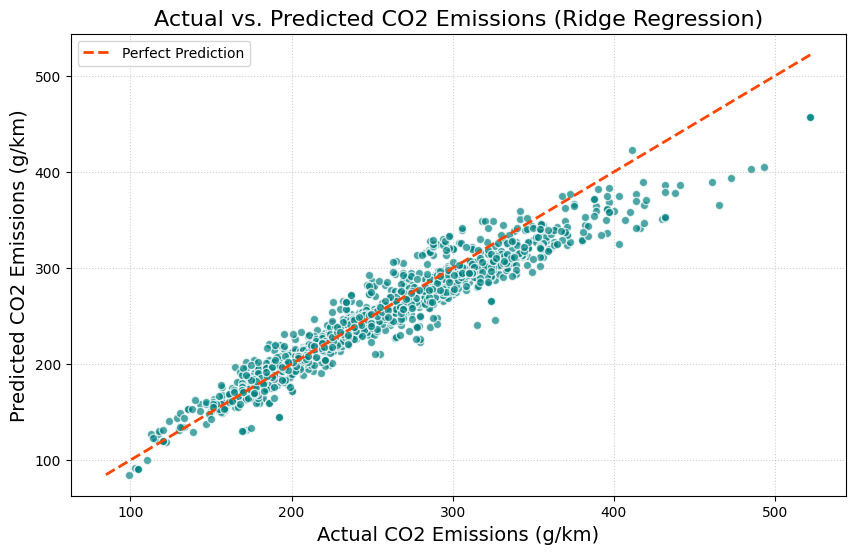

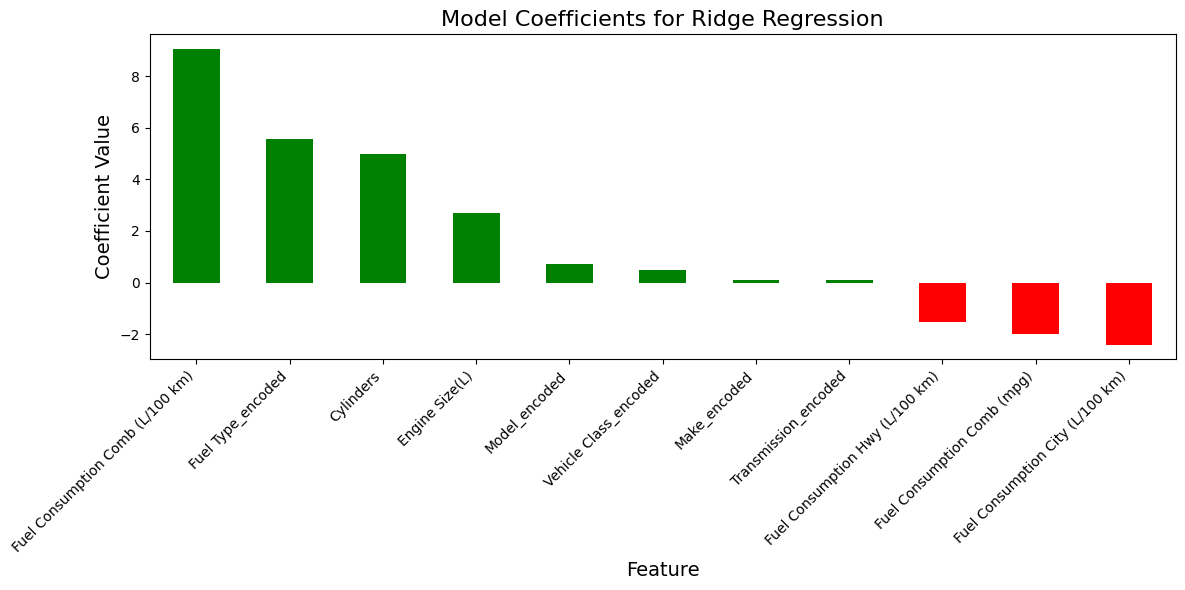

In [18]:
best_model_name = "Ridge Regression" if isinstance(best_model, Ridge) else "LinearRegression"
y_pred_best = best_model.predict(X_test) 
plot_actual_vs_predicted(y_test, y_pred_best, best_model_name)
plot_coefficients(coefficients, best_model_name)